 start self.b=-0.18584851920604706
self.opor_idx=array([0, 3, 6], dtype=int64)
np.sum(self.lambdas*self.y)=3.725290298461914e-09
np.mean(self.y[self.opor_idx] - np.sum(self.y[self.opor_idx] * self.lambdas[self.opor_idx] * self.kernel_transform(self.X[self.opor_idx], self.X[self.opor_idx]), axis=0))=-0.18584851920604706
stop self.b=-0.18584851920604706


array([1., 0.])

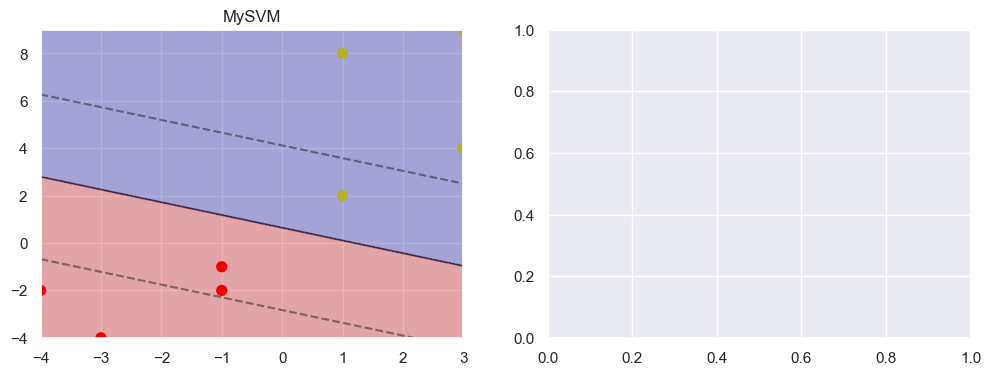

In [467]:
import numpy as np
class My_SVM:
    def __init__(self, kernel:str="linear", C:float=1, poly_deg:float = 3, rad_gamma:float=1, sigm_gamma:float = 13, sigm_betta:float = 0, max_iter:int = 1000):
        #Сразу при инициализации выбирается ядро, и его функция записывается в self.kernel
        self.kernel_transform = {
            "linear": lambda x_i, x_j: np.dot(x_i, x_j.T),
            "poly":lambda x_i, x_j: (1 + np.dot(x_i, x_j.T))**poly_deg,   
            "rad_func": lambda x_i, x_j: np.exp(-rad_gamma*np.sum((x_j - x_i[:, np.newaxis])**2, axis=-1)),
                        # np.exp(-gamma*np.sum((y - x[:,np.newaxis])**2, axis=-1))
            "sigm": lambda x_i, x_j: np.tanh(sigm_gamma*np.dot(x_i, x_j.T) + sigm_betta)
            }[kernel]
        
        self.C = C
        self.max_iter = max_iter

    def check_max_c(self, v, t, u):
        #Здесь отсекаем выход за пределы для нулевого  индекса

        t_zer_cheked = ((np.clip(a = v+t*u, a_min = 0, a_max = self.C) - v)[1] / u[1])#.reshape(-1, 1)
        # print(f"{t_zer_cheked=}")
        # здесь отсекаем выход за пределы для первого индекса
        return (np.clip(a = v+t_zer_cheked*u, a_min = 0, a_max = self.C) - v)[0] / u[0]


    def fit(self, X:np.ndarray, Y:np.ndarray):
        #Магическая (не совсем) штука, которая делает deepcopy без использования deepcopy
        #Тут прикол в том, что умножение создаёт новую ссылку на объект, если для него не указано другое.
        #Сответственно, так как это не листы, то мы переписываем ссылки для всех объектов вглубь,
        #По сути делая тот же самый deepcopy только средствами numpy
        self.X = X * 1
        self.y = Y*2 - 1
        # print(self.y)
        self.lambdas = np.zeros_like(self.y, dtype=np.float32)
        self.Kyiyj = self.kernel_transform(self.X, self.X) * self.y[:, np.newaxis] * self.y
        # print(f"{self.lambdas=}")
        # print(f"{self.Kyiyj=}")
        for _ in range(self.max_iter):
            for ind_M in range(self.lambdas.shape[0]):
            
                #пока выбирается рандомно, потом можно переделать на более интересный выбор
                ind_L = np.random.randint(0, self.lambdas.shape[0])
                # if ind_L == ind_M:
                #     ind_L-=1
                #     print("updated")
                
                # print(ind_M, ind_L)

                Q = self.Kyiyj[
                    [[ind_M, ind_M], [ind_M, ind_L]], 
                    [[ind_L, ind_M], [ind_L, ind_L]]
                    ]
                v_0_T = self.lambdas[[ind_M, ind_L]]
                v_0 = v_0_T.reshape(-1,1)
                k_0_T = 1 - self.lambdas @ self.Kyiyj[[ind_M, ind_L]].T
                # k0 = 1 - np.sum(self.lambdas * self.Kyiyj[[ind_M, ind_L]], axis=1) 
                # print(f"{k0=}, {k_0_T=}") 
                u = np.array([[-self.y[ind_L]],
                                [self.y[ind_M]]])


                t_zvezda = (k_0_T @ u) / ((u.T @ Q @ u)+ 1E-15)
                # print(f"{t_zvezda=}")
                t_zvezda = self.check_max_c(v_0, t_zvezda, u)

                self.lambdas[[ind_M, ind_L]] = (v_0_T  + t_zvezda * u.T)#.reshape(2)
                # print(f"{self.lambdas * self.y=}")
                # raise Exception("STOP")

        self.opor_idx, = np.nonzero(self.lambdas>1e-10)
        
        # print(self.y * self.lambdas)
        self.b = np.mean((1.0-np.sum(self.Kyiyj[self.opor_idx]*self.lambdas, axis=1))*self.y[self.opor_idx])
        print(f" start {self.b=}")
        # print(f"{np.sum(self.K[self.idx]*self.lambdas*self.y[self.idx].reshape(-1,1), axis=0)=}")
        # self.w = (self.K[self.idx]*self.lambdas).T @ self.y[self.idx].reshape(-1,1)
        print(f"{self.opor_idx=}")
        # print(f"{self.lambdas=}")
        print(f"{np.sum(self.lambdas*self.y)=}")
 
        print(f"{np.mean(self.y[self.opor_idx] - np.sum(self.y[self.opor_idx] * self.lambdas[self.opor_idx] * self.kernel_transform(self.X[self.opor_idx], self.X[self.opor_idx]), axis=0))=}")
        self.b = np.mean(self.y[self.opor_idx] - np.sum(self.lambdas[self.opor_idx] * self.y[self.opor_idx] * self.kernel_transform(self.X[self.opor_idx], self.X[self.opor_idx]), axis=0))
        print(f"stop {self.b=}")
    
    def decision_function(self, X:np.array):
        # print(f"{self.X[self.opor_idx]=}")
        # print(f"{X.T=}")
        # print(f"{self.kernel_transform(self.X[self.opor_idx], X)=}")
        # print(self.opor_idx)
        return np.sum(self.kernel_transform(X, self.X[self.opor_idx]) * self.y[self.opor_idx] * self.lambdas[self.opor_idx], axis=1) + self.b
    
    def predict(self, X:np.array):
        return (np.sign(self.decision_function(X))+1)//2

svm_my = My_SVM(max_iter=60, kernel="linear") 
X = np.array([[1,2],[3,4], [3,9], [-1,-2], [-3,-4], [-4,-2], [-1,-1], [1,8]])
y=np.array([1,1,1,0, 0, 0,0,1])
# svm_my.fit(np.array([[1,2],[3,4], [3,9], [-1,-2], [-3,-4], [-4,-2], [-1,-1], [1,8]]), Y=np.array([1,1,1,0, 0, 0,0,1]))

fig, axs = plt.subplots(nrows=1,ncols=2,figsize=(12,4))
test_plot(X, y, svm_my, axs[0], "MySVM")
svm_my.predict(np.array([[1,2], [-3,-4]]))


self.b=-0.3113948705625745
self.b=-1.7909931608088823
 start self.b=-1.6009330071399734
self.opor_idx=array([ 3, 11, 14, 17, 19, 20, 23, 24, 25, 26, 30, 31, 40, 41, 42, 45, 56,
       59, 60, 65, 71, 74, 83, 88, 90], dtype=int64)
np.sum(self.lambdas*self.y)=5.774199962615967e-08
np.mean(self.y[self.opor_idx] - np.sum(self.y[self.opor_idx] * self.lambdas[self.opor_idx] * self.kernel_transform(self.X[self.opor_idx], self.X[self.opor_idx]), axis=0))=-1.600933007139973
stop self.b=-1.600933007139973
self.b=4.212270396421304
 start self.b=26.290609084147754
self.opor_idx=array([ 2,  8, 12, 14, 19, 21, 22, 23, 24, 25, 29, 32, 34, 36, 37, 38, 46,
       51, 56, 62, 66, 74, 75, 77, 78, 83, 84, 85, 92, 94, 96],
      dtype=int64)
np.sum(self.lambdas*self.y)=-3.7549762055277824e-07
np.mean(self.y[self.opor_idx] - np.sum(self.y[self.opor_idx] * self.lambdas[self.opor_idx] * self.kernel_transform(self.X[self.opor_idx], self.X[self.opor_idx]), axis=0))=26.29060908414771
stop self.b=26.2906090841477

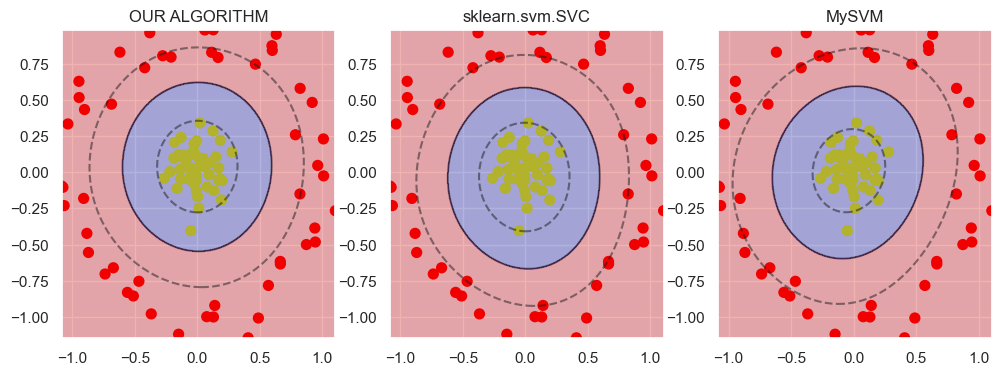

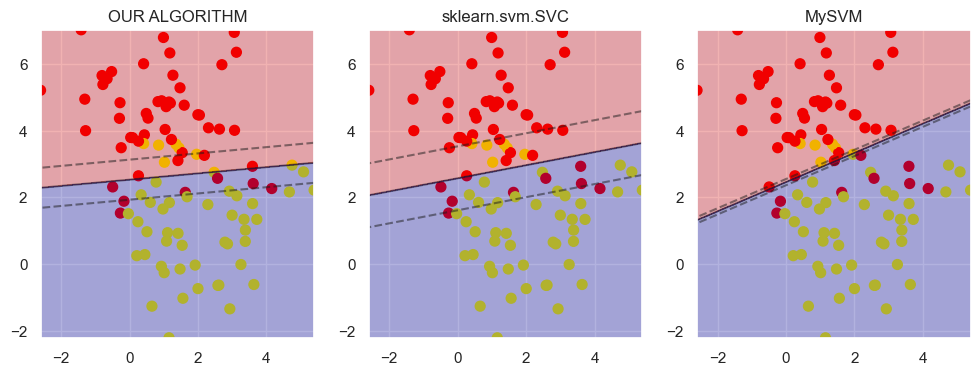

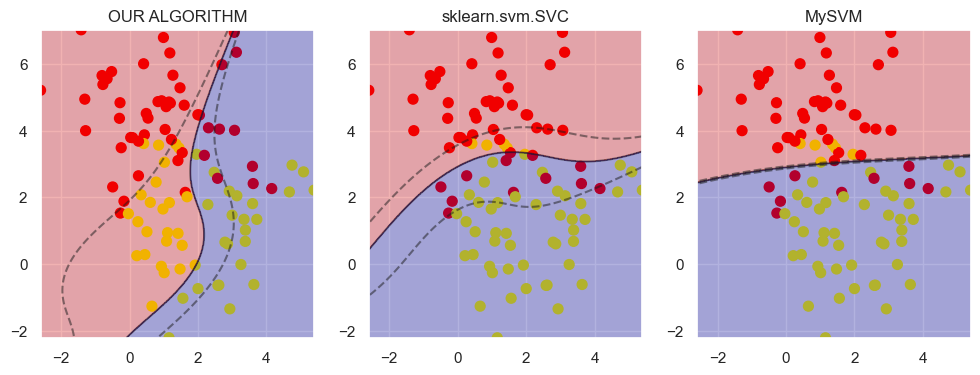

In [466]:
import numpy as np

class SVM:
  def __init__(self, kernel='linear', C=10000.0, max_iter=100, degree=3, gamma=1):
    self.kernel = {'poly'  : lambda x,y: np.dot(x, y.T)**degree,
                   'rbf'   : lambda x,y: np.exp(-gamma*np.sum((y - x[:,np.newaxis])**2, axis=-1)),
                   'linear': lambda x,y: np.dot(x, y.T)}[kernel]
    self.C = C
    self.max_iter = max_iter

  def restrict_to_square(self, t, v0, u):
    t = (np.clip(v0 + t*u, 0, self.C) - v0)[1]/u[1]
    return (np.clip(v0 + t*u, 0, self.C) - v0)[0]/u[0]

  def fit(self, X, y):
    self.X = X.copy()
    self.y = y * 2 - 1
    self.lambdas = np.zeros_like(self.y, dtype=float)
    self.K = self.kernel(self.X, self.X) * self.y[:,np.newaxis] * self.y
    
    for _ in range(self.max_iter):
      for idxM in range(len(self.lambdas)):
        idxL = np.random.randint(0, len(self.lambdas))
        Q = self.K[[[idxM, idxM], [idxL, idxL]], [[idxM, idxL], [idxM, idxL]]]
        v0 = self.lambdas[[idxM, idxL]]
        k0 = 1 - np.sum(self.lambdas * self.K[[idxM, idxL]], axis=1)
        u = np.array([-self.y[idxL], self.y[idxM]])
        t_max = np.dot(k0, u) / (np.dot(np.dot(Q, u), u) + 1E-15)
        self.lambdas[[idxM, idxL]] = v0 + u * self.restrict_to_square(t_max, v0, u)
    
    idx, = np.nonzero(self.lambdas > 1E-15)
    self.b = np.mean((1.0 - np.sum(self.K[idx] * self.lambdas, axis=1)) * self.y[idx])
    print(f"{self.b=}")
  
  def decision_function(self, X):
    return np.sum(self.kernel(X, self.X) * self.y * self.lambdas, axis=1) + self.b

  def predict(self, X):
    return (np.sign(self.decision_function(X)) + 1) // 2


svm = SVM(max_iter=3)
X = np.array([[1,2],[3,4], [3,9], [-1,-2], [-3,-4], [-4,-2], [-1,-1], [1,8]])
y=np.array([1,1,1,0, 0, 0,0,1])
svm.fit(X, y=y)

######### TESTS ############
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from sklearn.datasets import make_blobs, make_circles
from matplotlib.colors import ListedColormap

def test_plot(X, y, svm_model, axes, title):
  plt.axes(axes)
  xlim = [np.min(X[:, 0]), np.max(X[:, 0])]
  ylim = [np.min(X[:, 1]), np.max(X[:, 1])]
  xx, yy = np.meshgrid(np.linspace(*xlim, num=700), np.linspace(*ylim, num=700))
  rgb=np.array([[210, 0, 0], [0, 0, 150]])/255.0
  
  svm_model.fit(X, y)
  # print(np.c_[xx.ravel(), yy.ravel()])
  z_model = svm_model.decision_function(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)
  
  plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='autumn')
  plt.contour(xx, yy, z_model, colors='k', levels=[-1, 0, 1], alpha=0.5, linestyles=['--', '-', '--'])
  plt.contourf(xx, yy, np.sign(z_model.reshape(xx.shape)), alpha=0.3, levels=2, cmap=ListedColormap(rgb), zorder=1)
  plt.title(title)

X, y = make_circles(100, factor=.1, noise=.1)
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
test_plot(X, y, SVM(kernel='rbf', C=10, max_iter=3, gamma=1), axs[0], 'OUR ALGORITHM')
test_plot(X, y, SVC(kernel='rbf', C=10, gamma=1), axs[1], 'sklearn.svm.SVC')
test_plot(X, y, My_SVM(kernel='rad_func', max_iter=100, rad_gamma=1), axs[2], "MySVM")
# raise Exception("STOP")

X, y = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=1.4)
fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
test_plot(X, y, SVM(kernel='linear', C=10, max_iter=3), axs[0], 'OUR ALGORITHM')
test_plot(X, y, SVC(kernel='linear', C=10), axs[1], 'sklearn.svm.SVC')
test_plot(X, y, My_SVM(kernel='linear', C=10, max_iter=3), axs[2], "MySVM")

fig, axs = plt.subplots(nrows=1,ncols=3,figsize=(12,4))
test_plot(X, y, SVM(kernel='poly', C=5, max_iter=3, degree=3), axs[0], 'OUR ALGORITHM')
test_plot(X, y, SVC(kernel='poly', C=5, degree=3), axs[1], 'sklearn.svm.SVC')
test_plot(X, y, My_SVM(kernel='poly', C=5, poly_deg=3, max_iter=3), axs[2], "MySVM")

array([[ 5,  8, 11],
       [11, 18, 25]])

array([[ 0.        ,  0.        ],
       [ 2.72367972,  3.63157296],
       [ 3.54306363, 10.62919089],
       [-0.        , -0.        ],
       [-0.        , -0.        ],
       [-0.        , -0.        ],
       [-0.        , -0.        ],
       [ 0.794487  ,  6.355896  ]])